In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

data = pd.read_csv('../data/others/data_plos_hnsc_lognorm_nozscore.csv', index_col=0)
data_pyde = pd.read_csv('../data/others/data_plos_hnsc_pydeseq.csv')
cons = pd.read_csv('../results/connections_lognorm_hnsc.csv')
gtf = pd.read_csv(
    '../../engines/gencode.v47.basic.annotation.gtf',
    sep='\t',
    comment='#',
    header=None,
    names=[
        'seqname', 'source', 'feature', 'start', 'end',
        'score', 'strand', 'frame', 'attribute'
    ]
)

# Parse gene names
gtf['gene_id'] = gtf['attribute'].str.extract(r'gene_id "([^"]+)"')
gtf['gene_name'] = gtf['attribute'].str.extract(r'gene_name "([^"]+)"')
gtf = gtf[['gene_id', 'gene_name']]
mapping_dict = dict(zip(gtf['gene_name'], gtf['gene_id']))
cleaned_dict = {k: v.split('.')[0] for k, v in mapping_dict.items()}
rename_dict = {v: k for k, v in cleaned_dict.items()}

# Rename columns in data
df = data.rename(columns=rename_dict)
df_pyde = data_pyde.rename(columns=rename_dict)
deg = pd.read_csv('../results/deg_results_hnsc_pydeseq.csv', index_col=0)
deg = deg.T
deg.columns = deg.columns.str.split('.').str[0]
deg = deg.rename(columns=rename_dict)

# Get class labels
classes = df['Class'].unique()
if len(classes) != 2:
    raise ValueError("Expected exactly two classes for fold change calculation.")

class1, class2 = classes

# Separate samples by class
df_class1 = df[df['Class'] == class1]
df_class2 = df[df['Class'] == class2]

correlaciones = []
p_cor = []
fold_changes_mrna = []
padj_mrna = []

# Calculate correlation and fold change per miRNA–mRNA pair
for _, row in cons.iterrows():
    col1 = row["miRNA"]
    col2 = row["mRNA"]

    # Correlation
    if col1 in df.columns and col2 in df.columns:
        r, p_value = pearsonr(df[col1], df[col2])
    else:
        r = None
        p_value = None
    
    correlaciones.append(r)
    p_cor.append(p_value)

    if col2 in df.columns:
        fc = deg.at['log2FoldChange', col2] if col2 in deg.columns else np.nan
        padj = deg.at['padj', col2] if col2 in deg.columns else np.nan
        fold_changes_mrna.append(fc)
        padj_mrna.append(padj)

# Add results to cons dataframe
cons["cor"] = correlaciones
cons["p_cor"] = p_cor
cons["FC_mRNA"] = fold_changes_mrna
cons["padj"] = padj_mrna


C:\Users\aoviedomadr\AppData\Local\Temp\ipykernel_6852\1745988335.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


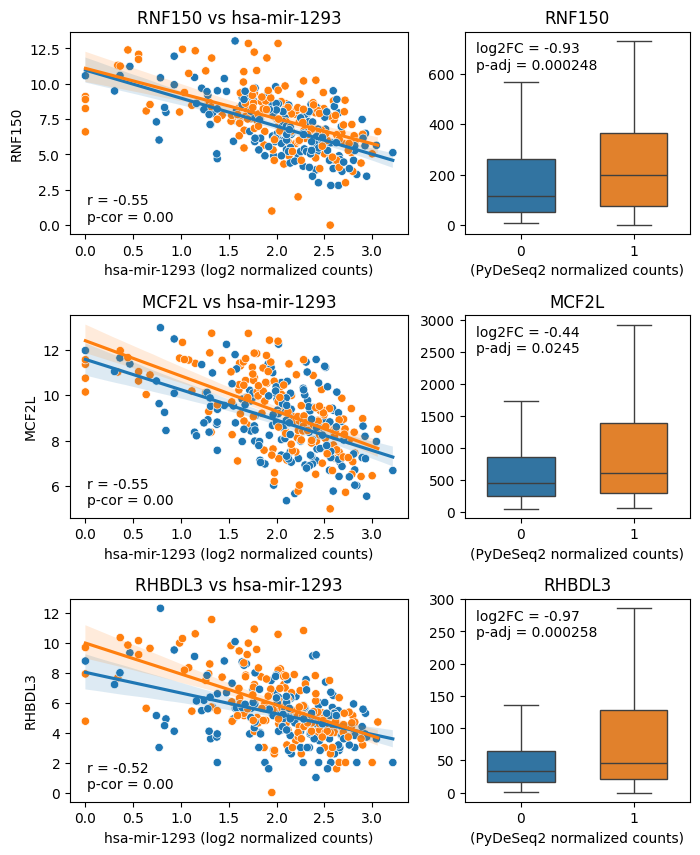

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# First 6 pairs
cons_mir1293 = cons[cons['miRNA'] == 'hsa-mir-1293'].reset_index(drop=True)
pairs = list(zip(cons_mir1293['miRNA'][:3], cons_mir1293['mRNA'][:3]))
n_pairs = len(pairs)

# Define a consistent color palette for classes
classes = df['Class'].unique()
custom_colors = ['#1f77b4', '#ff7f0e']  # adjust as needed
palette = dict(zip(classes, custom_colors))

# Create figure with GridSpec
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(n_pairs, 2, figure=fig, width_ratios=[1.5, 1], hspace=0.4)

for i, (mir, mrna) in enumerate(pairs):
    # Scatterplot (left column)
    ax_scatter = fig.add_subplot(gs[i, 0])
    sns.scatterplot(x=mir, y=mrna, hue='Class', data=df, ax=ax_scatter, palette=palette, legend=False)
    
    # Regression lines per class
    for c in classes:
        sns.regplot(
            x=mir, y=mrna,
            data=df[df['Class']==c],
            scatter=False,
            ax=ax_scatter,
            color=palette[c]
        )
    
    ax_scatter.set_title(f'{mrna} vs {mir}')

    # Scatterplot annotation: only correlation
    cor_val = cons_mir1293.loc[i, 'cor']
    p_cor = cons_mir1293.loc[i, 'p_cor']
    scatter_text = f'r = {cor_val:.2f}\np-cor = {p_cor:.2f}'
    ax_scatter.text(
        0.05, 0.20, scatter_text,
        transform=ax_scatter.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    current_label = ax_scatter.get_xlabel()
    ax_scatter.set_xlabel(f"{current_label} (log2 normalized counts)")

    # Boxplot (right column)
    ax_box = fig.add_subplot(gs[i, 1])
    sns.boxplot(
        x='Class', y=mrna, data=df_pyde, ax=ax_box,
        width=0.6, palette=palette, hue='Class', dodge=False, legend=False, showfliers=False
    )
    ax_box.set_title(f'{mrna}')
    ax_box.set_ylabel('')
    ax_box.set_xlabel('')

    # Boxplot annotation: fold change and adjusted p-value
    fc_val = cons_mir1293.loc[i, 'FC_mRNA']
    padj_val = cons_mir1293.loc[i, 'padj']
    box_text = f'log2FC = {fc_val:.2f}\np-adj = {padj_val:.3g}'
    ax_box.text(
        0.05, 0.95, box_text,
        transform=ax_box.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    ax_box.set_xlabel("(PyDeSeq2 normalized counts)")

plt.tight_layout()
# plt.savefig('../figures/mir1293_1.svg', format='svg', dpi=300)
plt.show()

C:\Users\aoviedomadr\AppData\Local\Temp\ipykernel_6852\2363668061.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


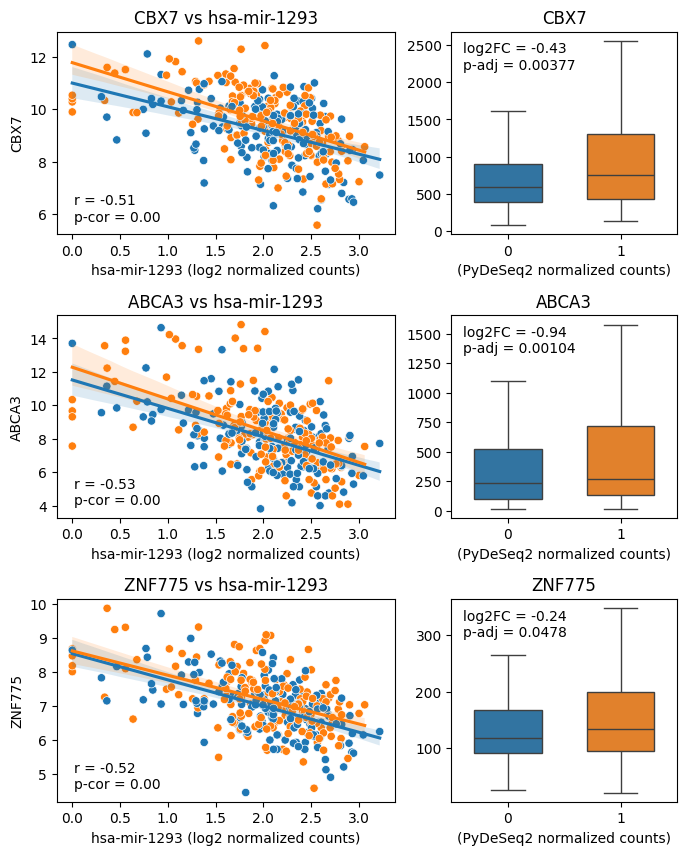

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# First 6 pairs
cons_mir1293 = cons[cons['miRNA'] == 'hsa-mir-1293'].reset_index(drop=True)
pairs = list(zip(cons_mir1293['miRNA'][3:6], cons_mir1293['mRNA'][3:6]))
n_pairs = len(pairs)

# Define a consistent color palette for classes
classes = df['Class'].unique()
custom_colors = ['#1f77b4', '#ff7f0e']  # adjust as needed
palette = dict(zip(classes, custom_colors))

# Create figure with GridSpec
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(n_pairs, 2, figure=fig, width_ratios=[1.5, 1], hspace=0.4)

for i, (mir, mrna) in enumerate(pairs):
    # Scatterplot (left column)
    ax_scatter = fig.add_subplot(gs[i, 0])
    sns.scatterplot(x=mir, y=mrna, hue='Class', data=df, ax=ax_scatter, palette=palette, legend=False)
    
    # Regression lines per class
    for c in classes:
        sns.regplot(
            x=mir, y=mrna,
            data=df[df['Class']==c],
            scatter=False,
            ax=ax_scatter,
            color=palette[c]
        )
    
    ax_scatter.set_title(f'{mrna} vs {mir}')

    # Scatterplot annotation: only correlation
    cor_val = cons_mir1293.loc[i+3, 'cor']
    p_cor = cons_mir1293.loc[i+3, 'p_cor']
    scatter_text = f'r = {cor_val:.2f}\np-cor = {p_cor:.2f}'
    ax_scatter.text(
        0.05, 0.20, scatter_text,
        transform=ax_scatter.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    current_label = ax_scatter.get_xlabel()
    ax_scatter.set_xlabel(f"{current_label} (log2 normalized counts)")

    # Boxplot (right column)
    ax_box = fig.add_subplot(gs[i, 1])
    sns.boxplot(
        x='Class', y=mrna, data=df_pyde, ax=ax_box,
        width=0.6, palette=palette, hue='Class', dodge=False, legend=False, showfliers=False
    )
    ax_box.set_title(f'{mrna}')
    ax_box.set_xlabel("(PyDeSeq2 normalized counts)")
    ax_box.set_ylabel('')

    # Boxplot annotation: fold change and adjusted p-value
    fc_val = cons_mir1293.loc[i+3, 'FC_mRNA']
    padj_val = cons_mir1293.loc[i+3, 'padj']
    box_text = f'log2FC = {fc_val:.2f}\np-adj = {padj_val:.3g}'
    ax_box.text(
        0.05, 0.95, box_text,
        transform=ax_box.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

plt.tight_layout()
# plt.savefig('../figures/mir1293_2.svg', format='svg', dpi=300)
plt.show()

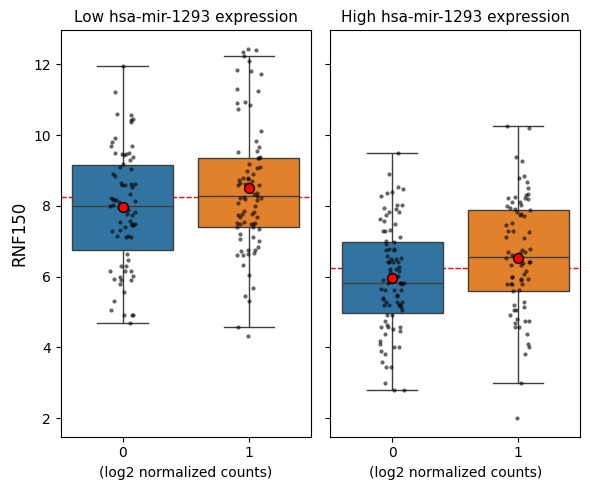

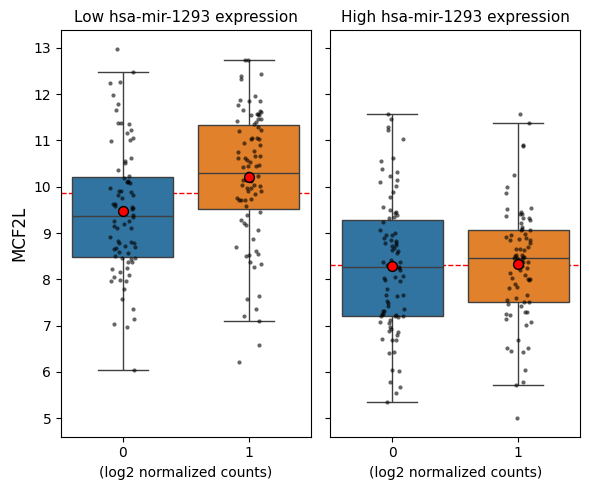

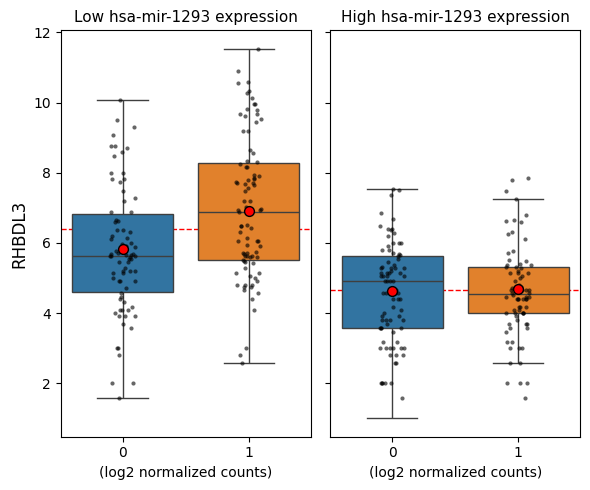

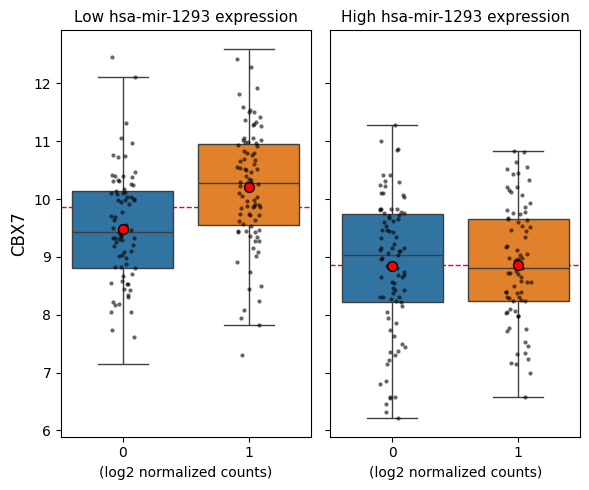

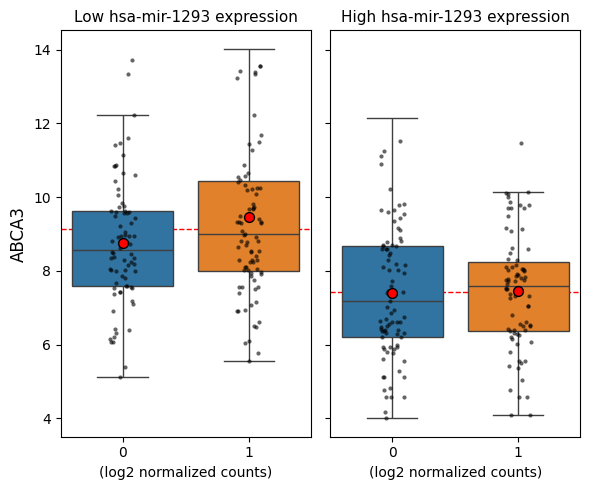

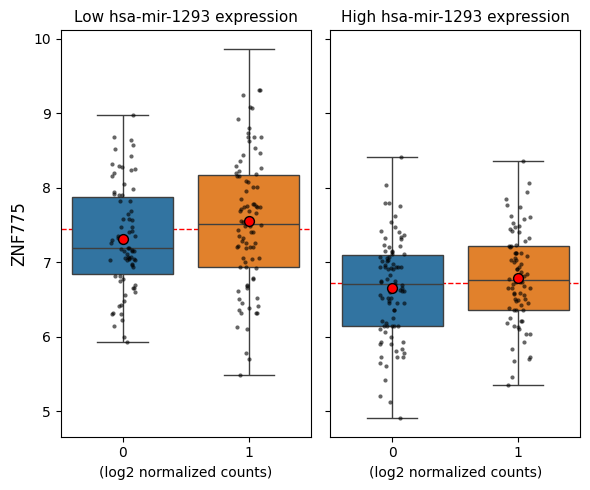

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu

# Pares miRNA–mRNA
cons_mir1293 = cons[cons['miRNA'] == 'hsa-mir-1293'].reset_index(drop=True)
pairs = list(zip(cons_mir1293['miRNA'][:6], cons_mir1293['mRNA'][:6]))
n_pairs = len(pairs)

for mir, mrna in pairs:
    # Copia para evitar warnings
    temp = df.copy()
    
    # Calcular la mediana del miRNA
    median_mir = temp[mir].median()
    
    # Categorizar expresión del miRNA
    temp['miR_expression_level'] = np.where(temp[mir] >= median_mir, 'High', 'Low')
    
    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(6, 5), sharey=True)
    plt.subplots_adjust(top=0.85)

    for i, level in enumerate(['Low', 'High']):
        data_level = temp[temp['miR_expression_level'] == level]

        # Línea de la media conjunta (detrás de los boxplots)
        mean_global = data_level[mrna].mean()
        axes[i].axhline(mean_global, color='red', linestyle='--', linewidth=1, zorder=0)
        
        # Boxplot
        sns.boxplot(
            x='Class', y=mrna, data=data_level, hue='Class',
            ax=axes[i], showfliers=False, zorder=1
        )
        # Stripplot (puntos individuales)

        # Filtrar outliers antes del stripplot
        q1 = data_level[mrna].quantile(0.25)
        q3 = data_level[mrna].quantile(0.75)
        iqr = q3 - q1

        filtered_data = data_level[
        (data_level[mrna] >= q1 - 1.5 * iqr) &
        (data_level[mrna] <= q3 + 1.5 * iqr)
        ]

        sns.stripplot(
            x='Class', y=mrna, data=filtered_data,
            color='black', size=3, jitter=True, dodge=False, alpha=0.6, ax=axes[i], zorder=2
        )

        # Media por clase → marcador puntual
        class_means = data_level.groupby('Class')[mrna].mean()
        for j, (cls, mean_val) in enumerate(class_means.items()):
            axes[i].scatter(
                j, mean_val, color='red', s=50, edgecolor='black', zorder=3, label='Class mean' if j == 0 else ""
            )

        # Etiquetas
        axes[i].set_title(f'{level} {mir} expression', fontsize=11)
        axes[i].set_xlabel('(log2 normalized counts)', fontsize=10)
        if i == 0:
            axes[i].set_ylabel(mrna, fontsize=12)
        else:
            axes[i].set_ylabel('')

        # Test estadístico (Wilcoxon o Mann–Whitney)
        classes = data_level['Class'].unique()
        if len(classes) == 2:
            group1 = data_level[data_level['Class'] == classes[0]][mrna]
            group2 = data_level[data_level['Class'] == classes[1]][mrna]
            if len(group1) == len(group2):
                stat, pval = wilcoxon(group1, group2)
            else:
                stat, pval = mannwhitneyu(group1, group2)
        else:
            pval = np.nan

        axes[i].legend().set_visible(False)

    # plt.suptitle(f'{mir} vs {mrna}', fontsize=14)
    plt.tight_layout()
    # plt.savefig(f'../figures/{mir}_{mrna}_mirna_expression.svg', format='svg', dpi=300)
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu

# Lista para almacenar resultados
results = []

# Pares miRNA–mRNA
cons_mir1293 = cons[cons['miRNA'] == 'hsa-mir-1293'].reset_index(drop=True)
pairs = list(zip(cons_mir1293['miRNA'][:6], cons_mir1293['mRNA'][:6]))
n_pairs = len(pairs)

for mir, mrna in pairs:
    temp = df.copy()
    
    # Categorizar según la mediana
    median_mir = temp[mir].median()
    temp['miR_expression_level'] = np.where(temp[mir] >= median_mir, 'High', 'Low')
    
    # --- Medias y conteos por clase y expresión ---
    summary = (
        temp.groupby(['miR_expression_level', 'Class'])[mrna]
        .agg(['count', 'mean'])
        .reset_index()
    )

    # --- Media general por nivel de expresión ---
    mean_by_expr = temp.groupby('miR_expression_level')[mrna].mean().to_dict()

    # --- Tests estadísticos entre clases dentro de cada grupo ---
    pvals_class = {}
    for level in ['Low', 'High']:
        data_level = temp[temp['miR_expression_level'] == level]
        classes = data_level['Class'].unique()
        if len(classes) == 2:
            g1 = data_level[data_level['Class'] == classes[0]][mrna]
            g2 = data_level[data_level['Class'] == classes[1]][mrna]
            if len(g1) == len(g2):
                stat, pval = wilcoxon(g1, g2)
            else:
                stat, pval = mannwhitneyu(g1, g2)
            pvals_class[level] = pval
        else:
            pvals_class[level] = np.nan

    # --- Test entre High vs Low (combinando clases) ---
    g_low = temp[temp['miR_expression_level'] == 'Low'][mrna]
    g_high = temp[temp['miR_expression_level'] == 'High'][mrna]
    if len(g_low) == len(g_high):
        stat, pval_global = wilcoxon(g_low, g_high)
    else:
        stat, pval_global = mannwhitneyu(g_low, g_high)

    # --- Guardar todo en una fila del resultado ---
    result_entry = {
        'miRNA': mir,
        'mRNA': mrna,
        # Conteos y medias por clase y nivel
        **{
            f"{row['miR_expression_level']}_{row['Class']}_count": row['count']
            for _, row in summary.iterrows()
        },
        **{
            f"{row['miR_expression_level']}_{row['Class']}_mean": row['mean']
            for _, row in summary.iterrows()
        },
        # Medias generales
        'Low_mean_overall': mean_by_expr.get('Low', np.nan),
        'High_mean_overall': mean_by_expr.get('High', np.nan),
        # p-valores
        'pval_Low_between_classes': pvals_class.get('Low', np.nan),
        'pval_High_between_classes': pvals_class.get('High', np.nan),
        'pval_High_vs_Low_all': pval_global,
    }

    results.append(result_entry)

# Convertir a DataFrame final
summary_df = pd.DataFrame(results)

# Mostrar o guardar
# summary_df.to_csv('../results/mir1293_interaction_metrics.csv', index=False)

          miRNA    mRNA  High_0_count  High_1_count  Low_0_count  Low_1_count  \
0  hsa-mir-1293  RNF150            87            78           78           87   
1  hsa-mir-1293   MCF2L            87            78           78           87   
2  hsa-mir-1293  RHBDL3            87            78           78           87   
3  hsa-mir-1293    CBX7            87            78           78           87   
4  hsa-mir-1293   ABCA3            87            78           78           87   
5  hsa-mir-1293  ZNF775            87            78           78           87   

   High_0_mean  High_1_mean  Low_0_mean  Low_1_mean  Low_mean_overall  \
0     5.973200     6.532628    7.968636    8.491007          8.244068   
1     8.292008     8.336685    9.480501   10.212085          9.866245   
2     4.625008     4.689303    5.839743    6.921948          6.410360   
3     8.850148     8.856073    9.485731   10.202972          9.863912   
4     7.399293     7.457070    8.757682    9.457228          9.1265